<a href="https://colab.research.google.com/github/rocioromera911/Portafolio_RR/blob/main/PNL_PreguntasMl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Clasificador de preguntas pre-compra
Categorias:
PRODUCTO: CARACTERÍSTICA


*  FORMAS DE ENTRGA : ENVIO
*  FORMAS DE ENTRGA: RETIRO
*  MULTIPLE PREGUNTA
*  PRODUCTO: COMPATIBILIDAD
*  PUBLICACIONES
*  RESPUESTA OK

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# Cargar datos
df = pd.read_excel('/content/drive/MyDrive/ies 2023/2024/pnl/Clasificador de mensajes ML/Dataset_CL.xlsx')
print(df.columns)

Index([' Clasificacion', 'Pregunta'], dtype='object')


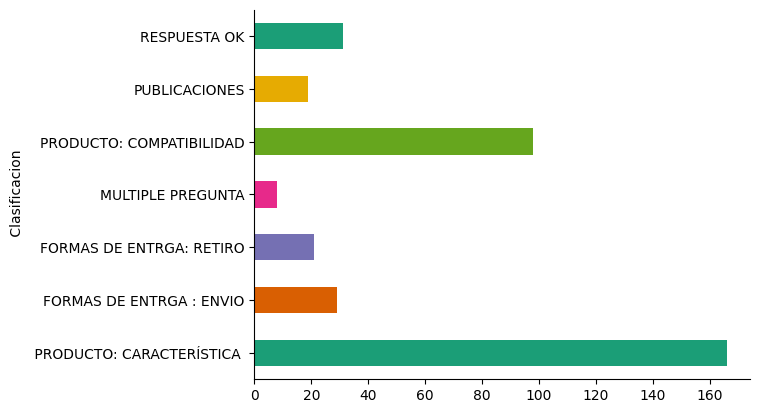

In [ ]:
df.groupby(' Clasificacion').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# Definir variables
Q = df['Pregunta']
Class = df[' Clasificacion']

# Primera división: 70% para entrenamiento y 30% para prueba
X_train, X_test, y_train, y_test = train_test_split(Q, Class, test_size=0.3, random_state=123)

# Segunda división: dividir el 20% de prueba en mitades (10% cada uno)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=123)

print("Data distribution:\n- Train: {} \n- Validation: {} \n- Test: {}".format(len(y_train), len(y_val), len(y_test)))


Data distribution:
- Train: 260 
- Validation: 56 
- Test: 56


minucula, token, *lem*. regex_token, patron de tk

In [ ]:

# Función de limpieza
def clean(Q):
    wn = WordNetLemmatizer() #crea una instancia del lematizador:
    stopword = set(stopwords.words('spanish')) # obtiene las palabras de parada en español.
    tokens = nltk.word_tokenize(Q)  #tokeniza las preguntas
    lower = [word.lower() for word in tokens] # todo a minusculas
    no_stopwords = [word for word in lower if word not in stopword] #Se eliminan las palabras de parada.
    no_alpha = [word for word in no_stopwords if word.isalpha()] #Se filtran solo los tokens alfabéticos
    lemm_text = [wn.lemmatize(word) for word in no_alpha]   #Se lematizan las palabras restantes.
    clean_text = " ".join(lemm_text)  #Se unen las palabras lematizadas en una sola cadena de texto
    return clean_text

df['clean'] = df['Pregunta'].map(clean)

Creating word clouds...


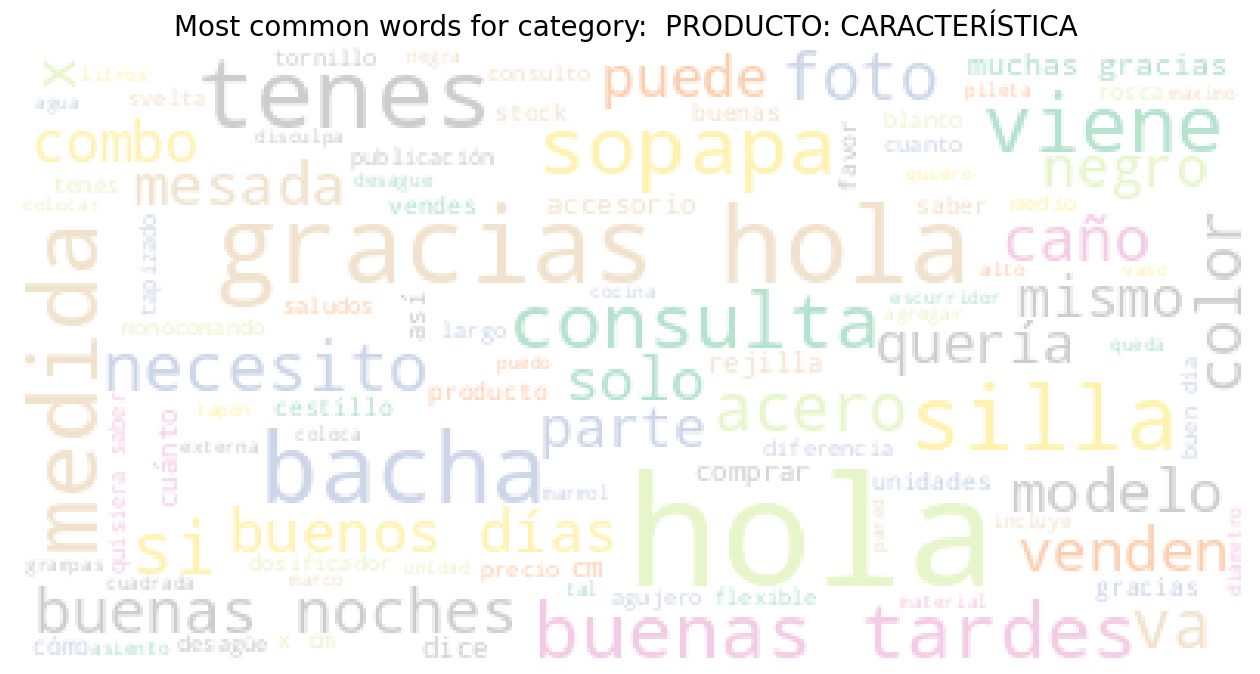

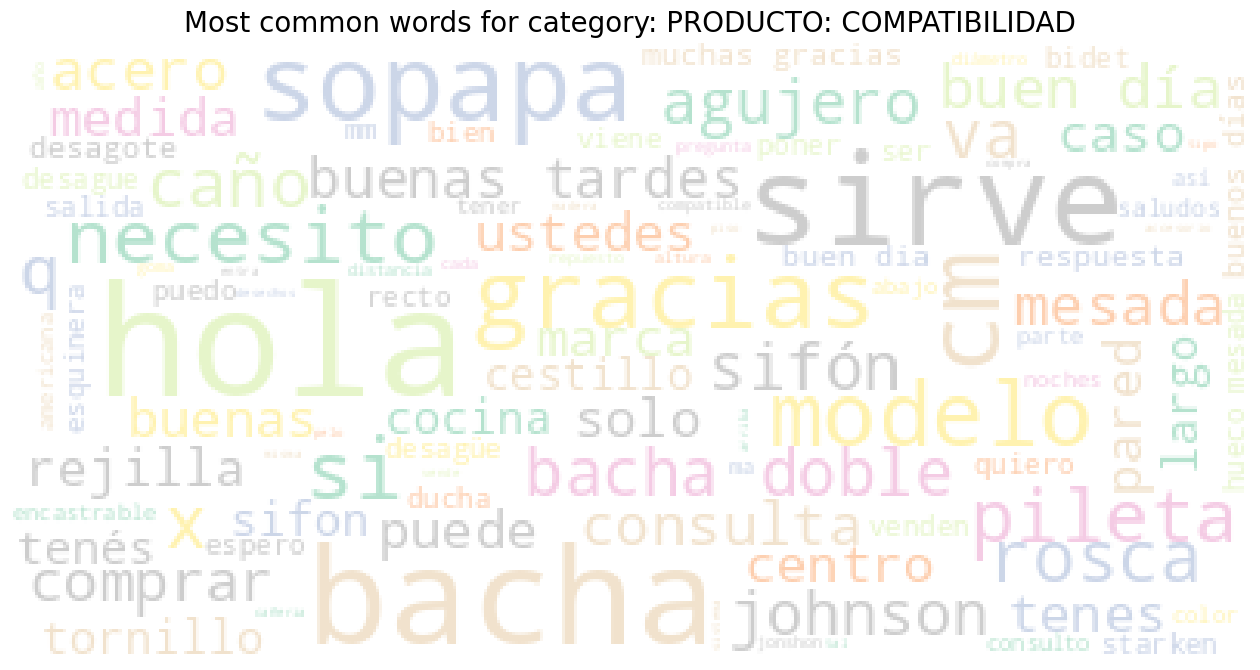

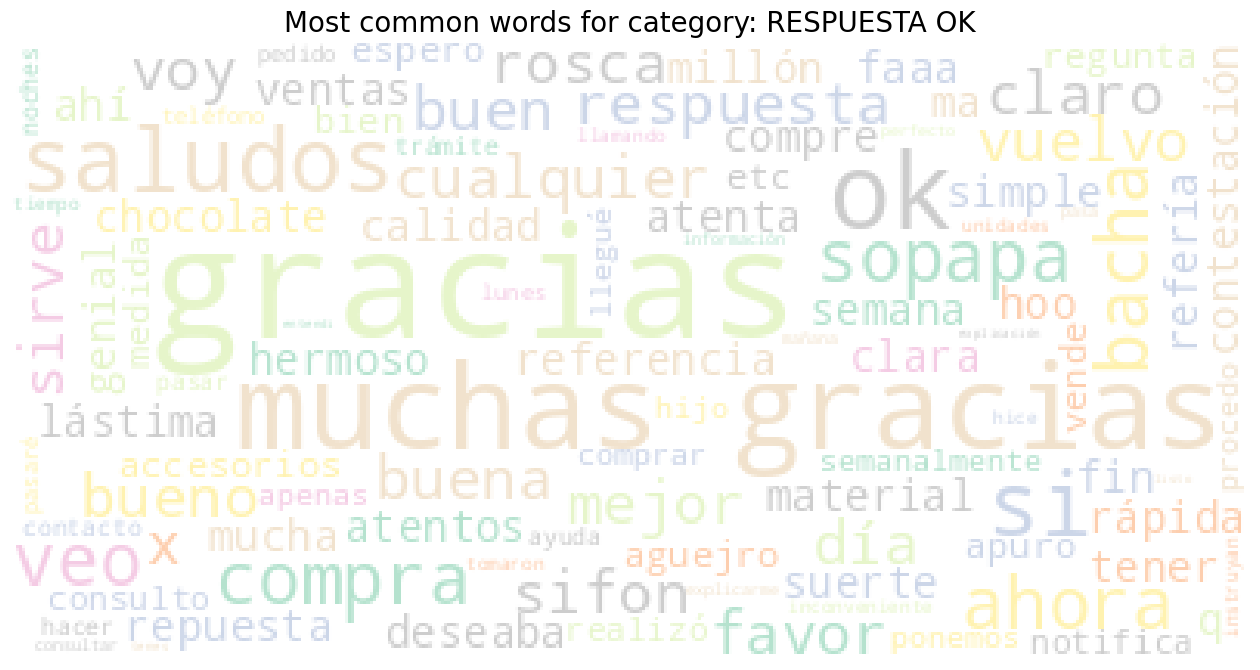

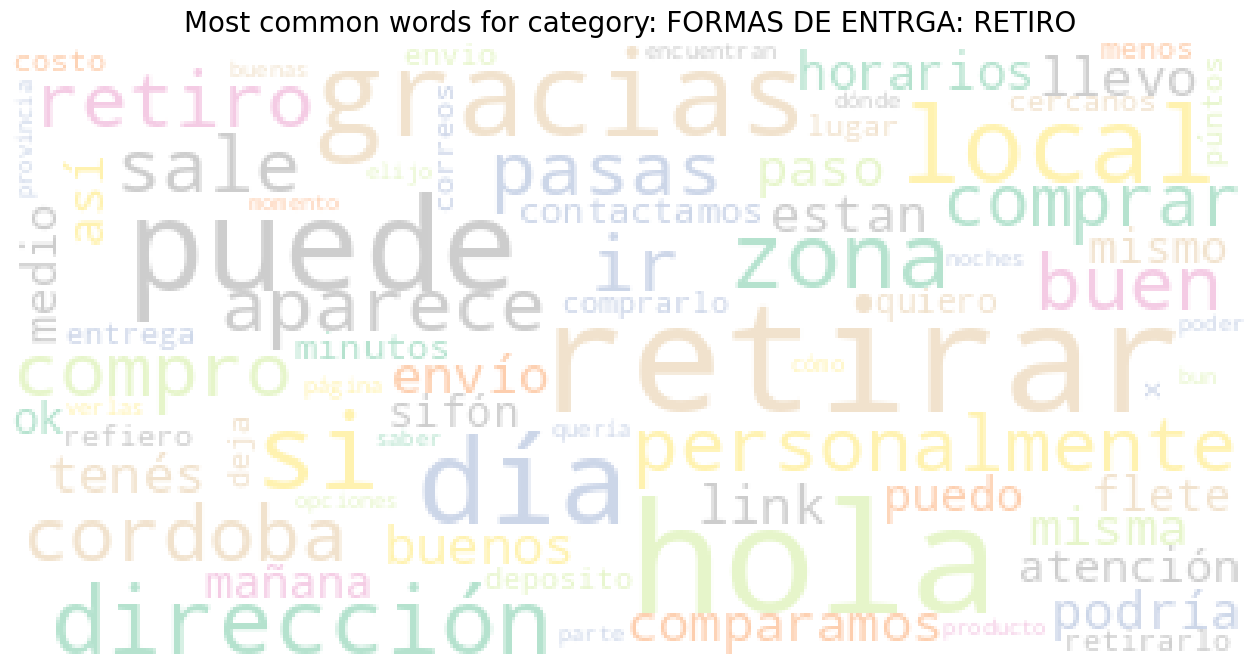

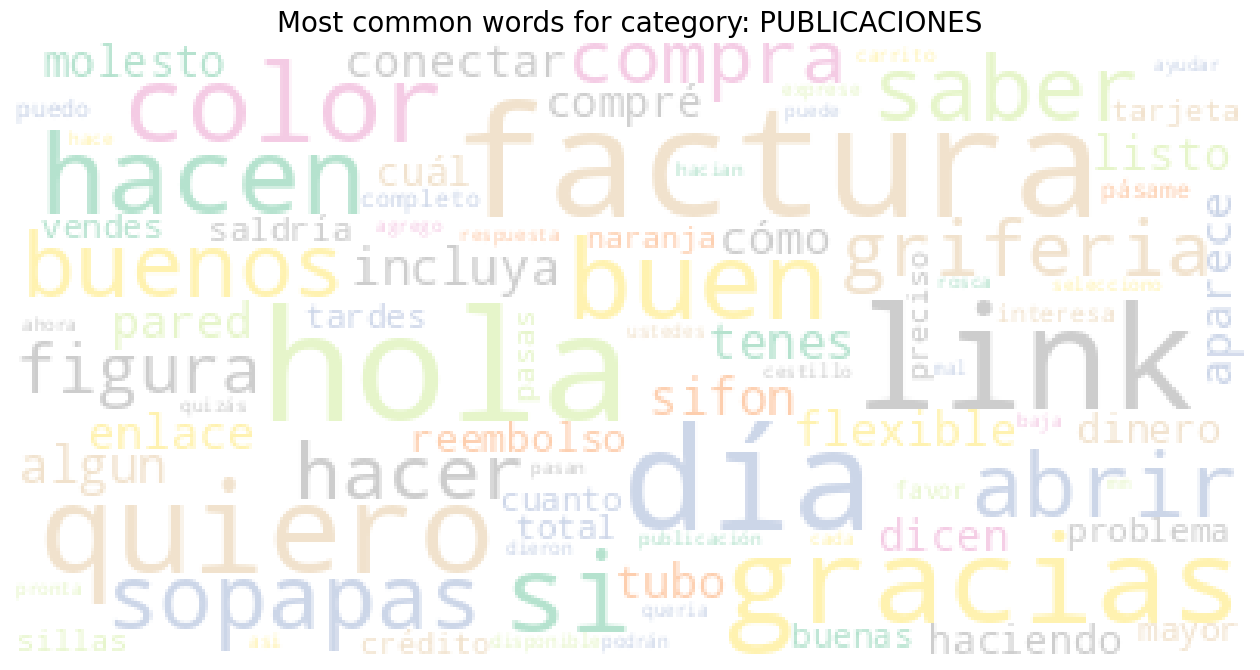

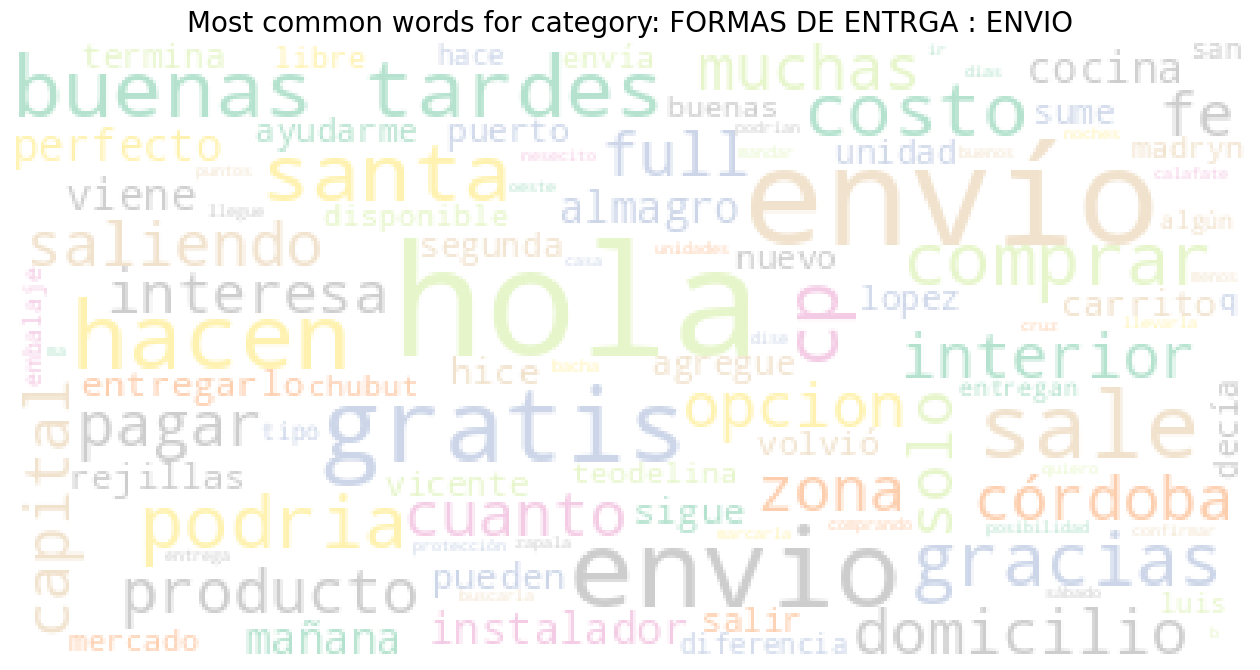

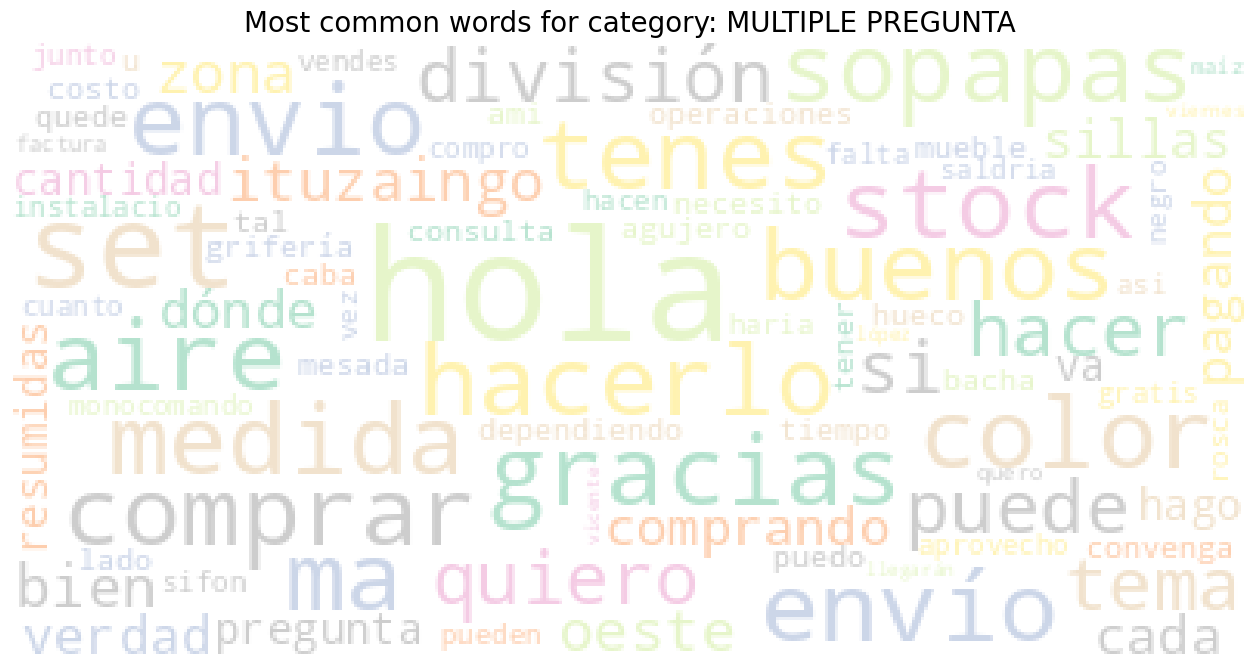

In [ ]:
def generate_wordcloud(words, category):
    plt.figure(figsize=(16, 13))
    wc = WordCloud(background_color="white", max_words=100, max_font_size=50)
    wc.generate(words)
    plt.title("Most common words for category: {}".format(category), fontsize=20)
    plt.imshow(wc.recolor(colormap='Pastel2', random_state=17), alpha=0.98)
    plt.axis('off')
    plt.show()
print("Creating word clouds...")
for category in df[' Clasificacion'].unique():
    words = " ".join(df[df[' Clasificacion'] == category]['clean'].values)
    generate_wordcloud(words, category)

In [ ]:
# Vectorización
tfidf_vect = TfidfVectorizer(analyzer='word')
tfidf_vect_fit = tfidf_vect.fit(X_train)

# Pipeline de preprocesamiento y vectorización
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(analyzer='word', tokenizer=nltk.word_tokenize, preprocessor=clean, stop_words=stopwords.words('spanish')))
])

X_train_tfidf = pipeline.fit_transform(X_train)
X_val_tfidf = pipeline.transform(X_val)
X_test_tfidf = pipeline.transform(X_test)

# Codificación de etiquetas
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)
# Balanceo de clases con SMOTE
smote = SMOTE(random_state=42)
X_train_tfidf_balanced, y_train_encoded_balanced = smote.fit_resample(X_train_tfidf, y_train_encoded)



/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
X_train_tfidf

<260x803 sparse matrix of type '<class 'numpy.float64'>'
	with 2102 stored elements in Compressed Sparse Row format>

In [ ]:
# Random Forest con Grid Search
rf = RandomForestClassifier()
parameters = {
    'n_estimators': [70, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

cv = GridSearchCV(rf, parameters, cv=5, scoring='accuracy')
cv.fit(X_train_tfidf_balanced, y_train_encoded_balanced)

print("Best Parameters:", cv.best_params_)
print("Best Estimador:", cv.best_estimator_)
print("Best Cross-validation Score:", cv.best_score_)


Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Best Estimador: RandomForestClassifier(n_estimators=150)
Best Cross-validation Score: 0.9511970671853958


In [ ]:
y_train_pred = best_model.predict(X_train_tfidf_balanced)

In [ ]:
# Evaluación del modelo en el conjunto de validación
best_model = cv.best_estimator_
y_val_pred = best_model.predict(X_val_tfidf)
val_accuracy = accuracy_score(y_val_encoded, y_val_pred)
val_precision = precision_score(y_val_encoded, y_val_pred, average='weighted',zero_division=1)
val_recall = recall_score(y_val_encoded, y_val_pred, average='weighted', zero_division=1)

print('Validation - Acc: {} / Precision: {} / Recall: {}'.format(val_accuracy, val_precision, val_recall))


Validation - Acc: 0.6785714285714286 / Precision: 0.749120670995671 / Recall: 0.6785714285714286


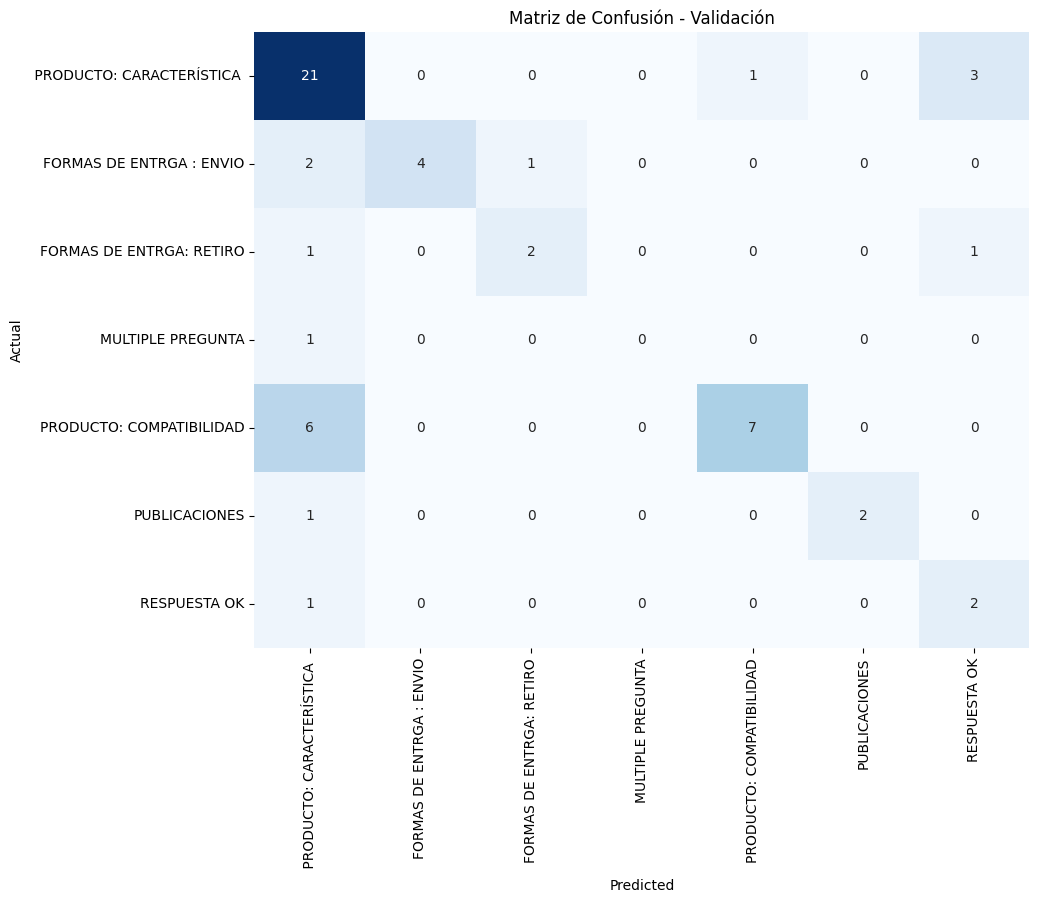

In [ ]:
# Matriz de confusión para el conjunto de validación
cm_val = confusion_matrix(y_val_encoded, y_val_pred, labels=label_encoder.transform(label_encoder.classes_))
plt.figure(figsize=(10, 8))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Matriz de Confusión - Validación')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
# Evaluación del modelo en el conjunto de prueba
y_test_pred = best_model.predict(X_test_tfidf)
test_accuracy = accuracy_score(y_test_encoded, y_test_pred)
test_precision = precision_score(y_test_encoded, y_test_pred, average='weighted', zero_division=1)
test_recall = recall_score(y_test_encoded, y_test_pred, average='weighted', zero_division=1)

print('Test - Acc: {} / Precision: {} / Recall: {}'.format(test_accuracy, test_precision, test_recall))


Test - Acc: 0.6607142857142857 / Precision: 0.6425324675324676 / Recall: 0.6607142857142857


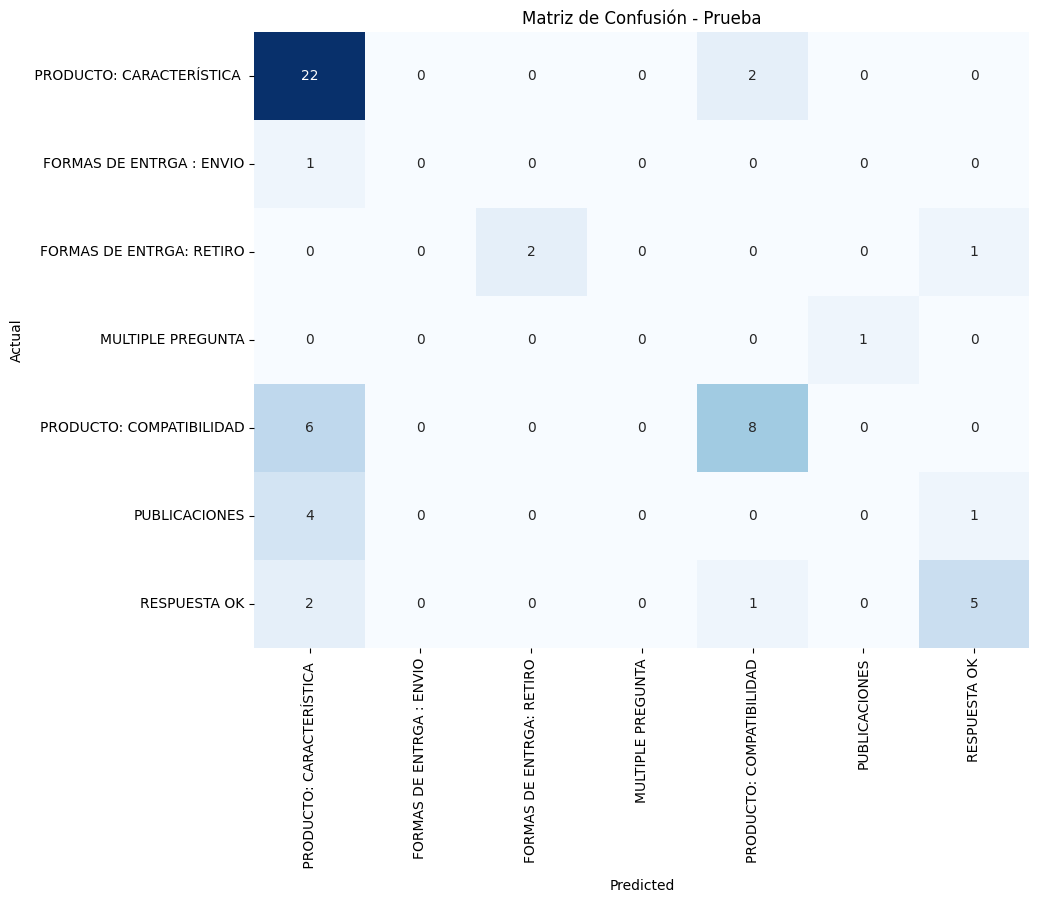

In [ ]:
# Matriz de confusión para el conjunto de prueba
cm_test = confusion_matrix(y_test_encoded, y_test_pred, labels=label_encoder.transform(label_encoder.classes_))
plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Matriz de Confusión - Prueba')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

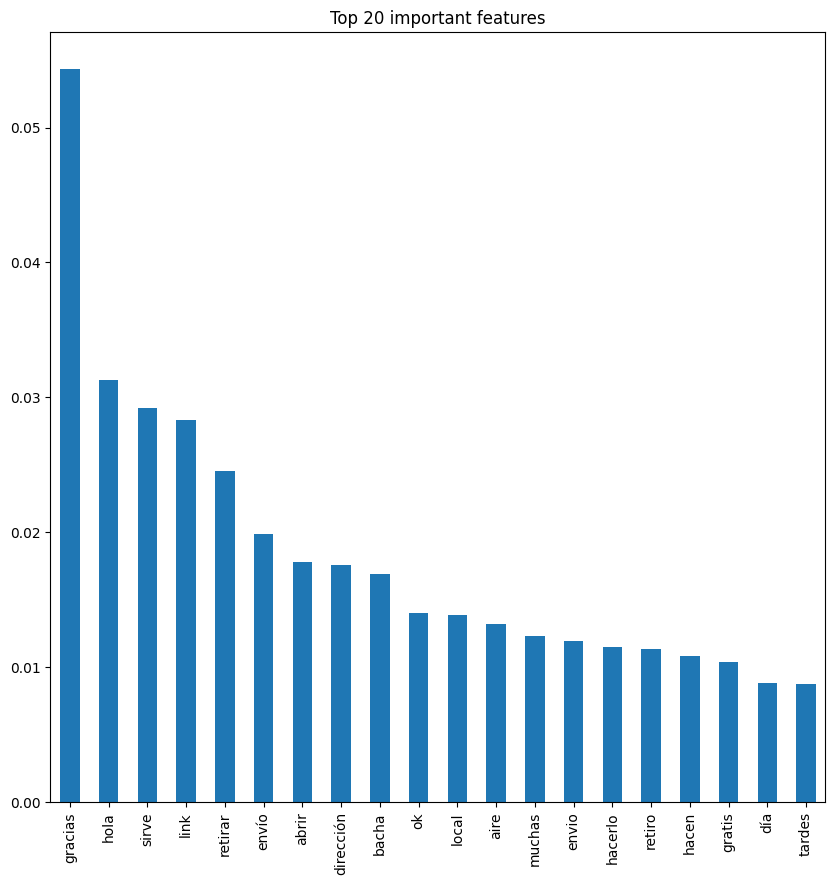

In [ ]:
# Importancia de las características
feat_importances = pd.Series(best_model.feature_importances_, index=pipeline.named_steps['vectorizer'].get_feature_names_out())
feat_importances.nlargest(20).plot(kind='bar', figsize=(10, 10))
plt.title("Top 20 important features")
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Genera el reporte de clasificación
print(classification_report(y_test_encoded, y_test_pred, target_names=label_encoder.classes_))


                            precision    recall  f1-score   support

 PRODUCTO: CARACTERÍSTICA        0.63      0.92      0.75        24
  FORMAS DE ENTRGA : ENVIO       0.00      0.00      0.00         1
  FORMAS DE ENTRGA: RETIRO       1.00      0.67      0.80         3
         MULTIPLE PREGUNTA       0.00      0.00      0.00         1
  PRODUCTO: COMPATIBILIDAD       0.73      0.57      0.64        14
             PUBLICACIONES       0.00      0.00      0.00         5
              RESPUESTA OK       0.71      0.62      0.67         8

                  accuracy                           0.66        56
                 macro avg       0.44      0.40      0.41        56
              weighted avg       0.61      0.66      0.62        56



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import pandas as pd

# Convertir los datos de validación y prueba a DataFrames con las predicciones
df_val = pd.DataFrame({
    'Pregunta': X_val,
    'Clasificacion Real': label_encoder.inverse_transform(y_val_encoded),
    'Clasificacion Predicha': label_encoder.inverse_transform(y_val_pred)
})

df_test = pd.DataFrame({
    'Pregunta': X_test,
    'Clasificacion Real': label_encoder.inverse_transform(y_test_encoded),
    'Clasificacion Predicha': label_encoder.inverse_transform(y_test_pred)
})

# Mostrar las primeras 10 preguntas del conjunto de validación con sus predicciones
print("\nEjemplos de predicciones en el conjunto de validación:")
print(df_val.head(10).to_string(index=False))

# Mostrar las primeras 10 preguntas del conjunto de prueba con sus predicciones
print("\nEjemplos de predicciones en el conjunto de prueba:")
print(df_test.head(10).to_string(index=False))




Ejemplos de predicciones en el conjunto de validación:
                                                                                                                                                                                                                                                                                                                        Pregunta         Clasificacion Real     Clasificacion Predicha
                                                                                                                                                                                             Quise comprar pero el envio me sale una locura.por donde estas para retirar?podrias agregar la opcion?,esta solo para envio.gracias   FORMAS DE ENTRGA : ENVIO   FORMAS DE ENTRGA: RETIRO
                                                                                                                                                                                                  